# Proyecto 1 - Autoencoders
## Denoising CelebA
- Ricardo Damián Hernández Ramírez
- 740356
- **Link Github**: https://github.com/RicardoHdz12/CelebA-Denoising-Autoencoder

[![celeba](https://mmlab.ie.cuhk.edu.hk/projects/CelebA/intro.png)](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)



El conjunto de datos CelebA es uno de los conjuntos de datos más populares en el campo del reconocimiento facial y la visión por computadora. Diseñado por el Laboratorio de Multimedia de la Universidad China de Hong Kong (CUHK), CelebA contiene más de `200,000` imágenes de caras de celebridades, con anotaciones detalladas que incluyen etiquetas de atributos faciales como género, edad, color de cabello, uso de gafas, expresión facial y más.




 El denoising autoencoder es una técnica de aprendizaje no supervisado que se utiliza para eliminar el ruido de las imágenes al aprender una representación latente significativa de los datos. Dado que CelebA proporciona una amplia variedad de imágenes de alta calidad de caras de celebridades, este conjunto de datos es ideal para entrenar un denoising autoencoder que pueda eliminar el ruido de las imágenes faciales y mejorar su calidad visual.





## Carga de los datos.
Debido a un error en el conjunto de datos CelebA en TensorFlow, actualmente no es posible descargarlo directamente. Por lo tanto, en este proyecto, optaremos por usar los datos disponibles en Kaggle a través de su API. Esta opción nos permitirá realizar todo el proceso, desde la descarga hasta la descompresión de los datos, directamente desde Google Colab, lo que facilitará nuestro flujo de trabajo y garantizará la disponibilidad de los datos necesarios para nuestro proyecto.




![error](https://i.stack.imgur.com/uNySQ.png)






In [1]:
import tensorflow as tf
import os
import glob
import pandas as pd

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ricardohdzz","key":"437bb97c1c57f8f67df94b1f56ed8dc1"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download jessicali9530/celeba-dataset
!unzip -d dataset celeba-dataset.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: dataset/img_align_celeba/img_align_c

# Preprocesamiento de Imágenes: Carga de Datos y Adición de Ruido

In [5]:
import tensorflow as tf
import random
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [6]:
# función para agregar ruido a una imagen
def add_noise(image, noise_factor=0.4):
    noisy_image = image + noise_factor * tf.random.normal(shape=tf.shape(image), mean=0., stddev=1.)
    return tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

# función para leer y preprocesar una imagen.
def read_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert pixel values to floating point in [0, 1]
    image = tf.image.resize(image, [128, 128])  # Resize the image to 128x128
    return image

# Obtener la lista de rutas de imágenes
image_paths = sorted(glob.glob(os.path.join('dataset', 'img_align_celeba', 'img_align_celeba', '*.jpg')))

# calcular el tamaño del conjunto de datos y el tamaño del conjunto de entrenamiento
dataset_size = len(image_paths)
train_size = int(0.8 * dataset_size)  # 80%  training, 20% testing

# Mezclar aleatoriamente los paths de las imagenes
random.shuffle(image_paths)

# Dividir en train y test
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Crear los datasets para train y test
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)

# Asignar la función de preprocesamiento a cada conjunto de datos
train_dataset = train_dataset.map(read_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(read_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Combinar las imagenes normales y las ruidosas para train
train_combined_dataset = tf.data.Dataset.zip((train_dataset, train_dataset.map(add_noise)))

#Combinar las imagenes normales y las ruidosas para test
test_combined_dataset = tf.data.Dataset.zip((test_dataset, test_dataset.map(add_noise)))

# Dividir el conjunto de datos combinado en imágenes originales y ruidosas para entrenamiento
train_dataset = train_combined_dataset.map(lambda x, y: (y, x))  # (original, noisy)

# Dividir el conjunto de datos combinado para test
test_dataset = test_combined_dataset.map(lambda x, y: (y, x))  # (original, noisy)

# Agrupa los ejemplos de entrenamiento en lotes de 128 elementos y 
# los carga en memoria anticipadamente para mejorar el rendimiento durante el entrenamiento del modelo.
train_dataset = train_dataset.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Agrupa en lotes de 128 y prefetch para mejorar rendimiento para test.
test_dataset = test_dataset.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



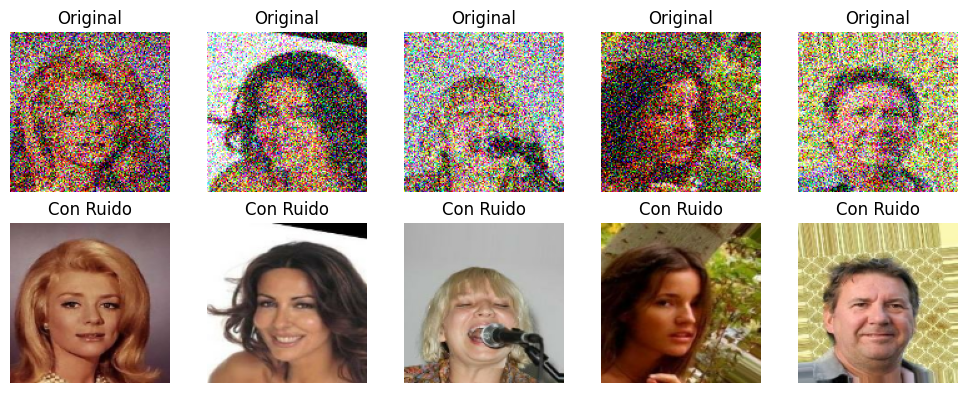

In [7]:
import matplotlib.pyplot as plt

# Extrae un lote de imágenes originales y ruidosas del conjunto de entrenamiento
original_images, noisy_images = next(iter(train_dataset))

# images to show
num_images_to_show = 5

# Grafica las imágenes originales y las imágenes con ruido
plt.figure(figsize=(10, 4))
for i in range(num_images_to_show):
    # Imagen original
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis('off')

    # Imagen con ruido
    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(noisy_images[i])
    plt.title("Con Ruido")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Denoiosing autoencoder

## Modelo 1
El codificador comienza con una capa de entrada que recibe imágenes con una forma de (128, 128, 3), es decir, imágenes de 128x128 píxeles en tres canales
(RGB).
A continuación, se aplica una capa de convolución con 32 filtros de tamaño 3x3, seguida de una función de activación ReLU.

Después de la primera capa convolucional, se aplica una capa de max pooling con un tamaño de ventana de 2x2 y un paso (stride) de 2, lo que reduce la resolución espacial de la salida a la mitad.
Se repite este patrón con dos capas adicionales de convolución y max pooling, con 64 y 128 filtros respectivamente.
Finalmente, se aplica una última capa de max pooling para obtener la representación codificada, que tiene una dimensión de (16, 16, 128), ya que la resolución de la imagen se ha reducido sucesivamente a la mitad en cada dirección espacial.

Decodificador:

El decodificador comienza con una capa de convolución con 128 filtros de tamaño 3x3, seguida de la activación ReLU.
Luego, se utilizan capas de up-sampling para aumentar la resolución espacial de la representación codificada. Estas capas de up-sampling aumentan la resolución a lo largo de cada dimensión espacial en un factor de 2.
Después de cada capa de up-sampling, se aplica una capa de convolución con 64 y luego 32 filtros de tamaño 3x3, seguida de la activación ReLU.
Finalmente, se utiliza una capa de convolución con 3 filtros de tamaño 3x3 y activación sigmoide para generar la imagen reconstruida. Dado que la imagen de salida debe tener la misma forma que la imagen de entrada original (128x128x3), se utiliza una función de activación sigmoide para comprimir los valores de píxeles a un rango entre 0 y 1.

Autoencoder:

El autoencoder se construye conectando la capa de entrada del codificador con la capa de salida del decodificador.
La estructura resultante es un modelo que toma una imagen con ruido como entrada y genera una versión denoised de la misma como salida.
Se compila el modelo utilizando el optimizador Adam y la función de pérdida binary crossentropy

In [ ]:
# Definir el modelo del autoencoder
input_shape = (128, 128, 3)
latent_dim = 64

# Codificador
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D(2, padding='same')(x)

# Decodificador
x = layers.Conv2D(128, 3, activation='relu', padding='same')(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = tf.keras.Model(encoder_inputs, decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenar el modelo
autoencoder.fit(train_dataset, epochs=10, validation_data=test_dataset)


Epoch 1/10
1267/1267 [==============================] - 442s 338ms/step - loss: 0.4932 - val_loss: 0.4855
Epoch 2/10
1267/1267 [==============================] - 412s 325ms/step - loss: 0.4848 - val_loss: 0.4847
Epoch 3/10
1267/1267 [==============================] - 409s 323ms/step - loss: 0.4838 - val_loss: 0.4831
Epoch 4/10
1267/1267 [==============================] - 410s 324ms/step - loss: 0.4832 - val_loss: 0.4834
Epoch 5/10
1267/1267 [==============================] - 411s 324ms/step - loss: 0.4828 - val_loss: 0.4824
Epoch 6/10
1267/1267 [==============================] - 410s 323ms/step - loss: 0.4825 - val_loss: 0.4835
Epoch 7/10
1267/1267 [==============================] - 409s 323ms/step - loss: 0.4822 - val_loss: 0.4826
Epoch 8/10
1267/1267 [==============================] - 408s 322ms/step - loss: 0.4821 - val_loss: 0.4821
Epoch 9/10
1267/1267 [==============================] - 408s 322ms/step - loss: 0.4819 - val_loss: 0.4818
Epoch 10/10
1267/1267 [=======================

4/4 [==============================] - 0s 16ms/step


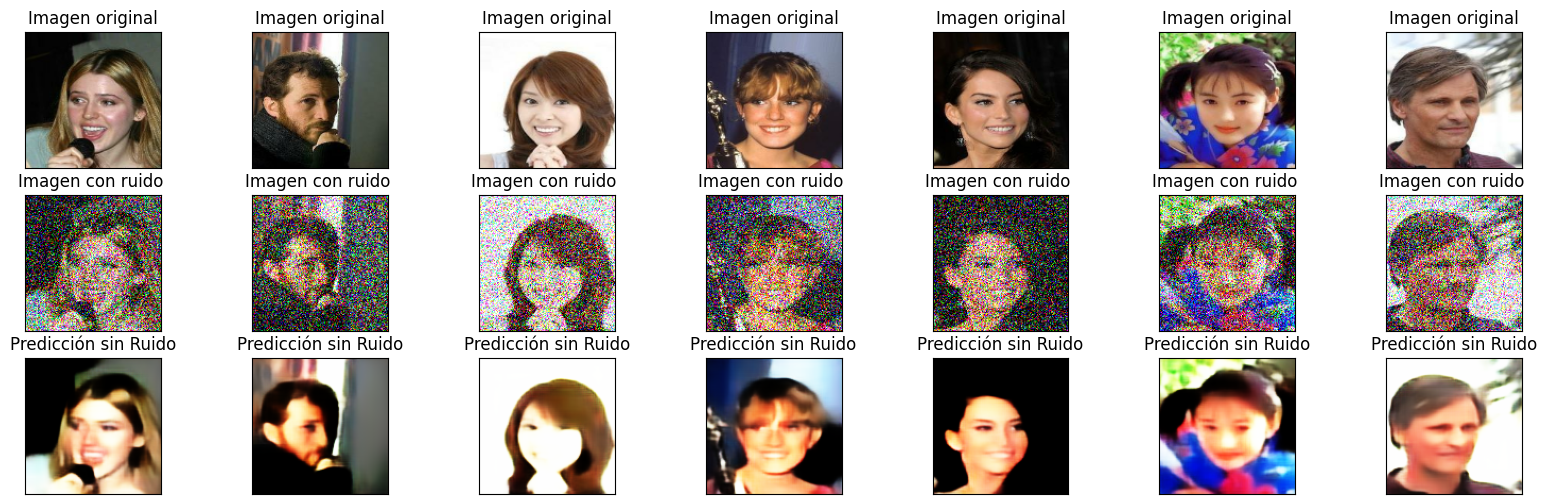

In [ ]:
# Obtener algunas muestras de datos de prueba
sample_originals, sample_noisy = next(iter(test_dataset))

# Obtener las predicciones del modelo para las imágenes con ruido
decoded_images = autoencoder.predict(sample_noisy)

n = 7  # número de muestras para graficar
plt.figure(figsize=(20, 6))
for i in range(n):
     # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_noisy[i])
    plt.title("Imagen original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen con ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(sample_originals[i])
    plt.title("Imagen con ruido ")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Predicción del modelo
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_images[i])
    plt.title("Predicción sin Ruido")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


 * Este primer denoising autoencoder es efectivo para eliminar el ruido de las imágenes.Toma imágenes ruidosas como entrada y produce imágenes limpias que se parecen mucho a las imágenes originales.

* Las imágenes predichas muestran que el ruido se ha eliminado en gran medida. Aunque las imágenes no son perfectamente claras, los retratos son visibles y reconocibles.

## Modelo 2
* En este modelo, se limitó el número de épocas a 6 debido a restricciones de tiempo y recursos computacionales en Google Colab. Debido al volumen considerable de imágenes en el conjunto de datos y la capacidad limitada de procesamiento, el tiempo de entrenamiento superaba las dos horas, lo que resultaba en desconexiones frecuentes en el entorno de ejecucion utilizado. Por lo tanto, se optó por un número de épocas que permitiera un entrenamiento eficiente dentro de los límites de tiempo disponibles

* El modelo 2 tiene una dimensionalidad latente más alta con latent_dim = 256, mientras que el modelo 1 tenía latent_dim = 64. Esto significa que el espacio latente en el modelo 2 es mucho más grande, lo que podría permitir una representación más compleja de los datos.

* Capas Conv2D y Tamaño de Filtros Diferentes: En el modelo 2, el número de filtros en las capas Conv2D del codificador y decodificador es diferente. Por ejemplo, en el modelo 2, la primera capa Conv2D del codificador tiene 64 filtros en comparación con los 32 filtros del modelo 1. Además, el tamaño del kernel también varía; en el modelo 2, se utilizan filtros de tamaño 3x3 en todas las capas Conv2D, mientras que en el modelo 1, las capas Conv2D utilizan filtros de tamaño 3x3, 3x3 y 3x3 para las capas 1, 2 y 3 respectivamente.

* Capas de Normalización y Dropout Adicionales: El modelo 2 incluye capas de BatchNormalization y Dropout después de algunas capas Conv2D del codificador. Estas capas adicionales pueden ayudar a estabilizar y regularizar el proceso de entrenamiento, lo que potencialmente mejora el rendimiento y la generalización del modelo.

* Regularización L2: El modelo 2 utiliza regularización L2 con un parámetro de penalización de 0.01 en algunas capas Conv2D. Esta regularización puede ayudar a prevenir el sobreajuste al penalizar los pesos grandes en la red neuronal.

* Función de Pérdida Diferente: Mientras que el modelo 1 utiliza la función de pérdida 'binary_crossentropy', el modelo 2 utiliza 'mean_squared_error' como función de pérdida. El error cuadrático medio penaliza las diferencias entre los píxeles de las imágenes originales y las imágenes reconstruidas de manera global. En problemas de denoising, donde el objetivo principal es obtener una imagen reconstruida lo más similar posible a la imagen original, esta función de pérdida puede ser apropiada, ya que busca minimizar la diferencia global entre las dos imágenes

* Callback EarlyStopping: En el modelo 2, se implementa un callback de EarlyStopping durante el entrenamiento, lo que detiene el entrenamiento si la pérdida de validación no mejora después de cierto número de épocas (en este caso, 5 épocas). Esto ayuda a evitar el sobreajuste y mejora la capacidad del modelo para generalizar a datos no vistos.



In [ ]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Definir el modelo del autoencoder
input_shape = (128, 128, 3)
latent_dim = 256

# Codificador
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D(2, padding='same')(x)

# Decodificador
x = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = tf.keras.Model(encoder_inputs, decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Definir el callback EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo con el callback EarlyStopping
autoencoder.fit(train_dataset, epochs=6, batch_size=12, validation_data=test_dataset, callbacks=[early_stopping_callback])

Epoch 1/6
1267/1267 [==============================] - 679s 516ms/step - loss: 0.1193 - val_loss: 0.0720
Epoch 2/6
1267/1267 [==============================] - 630s 497ms/step - loss: 0.0332 - val_loss: 0.0927
Epoch 3/6
1267/1267 [==============================] - 627s 495ms/step - loss: 0.0111 - val_loss: 0.0477
Epoch 4/6
1267/1267 [==============================] - 626s 494ms/step - loss: 0.0099 - val_loss: 0.0586
Epoch 5/6
1267/1267 [==============================] - 626s 494ms/step - loss: 0.0087 - val_loss: 0.1233
Epoch 6/6
1267/1267 [==============================] - 625s 494ms/step - loss: 0.0096 - val_loss: 0.0642


4/4 [==============================] - 0s 32ms/step


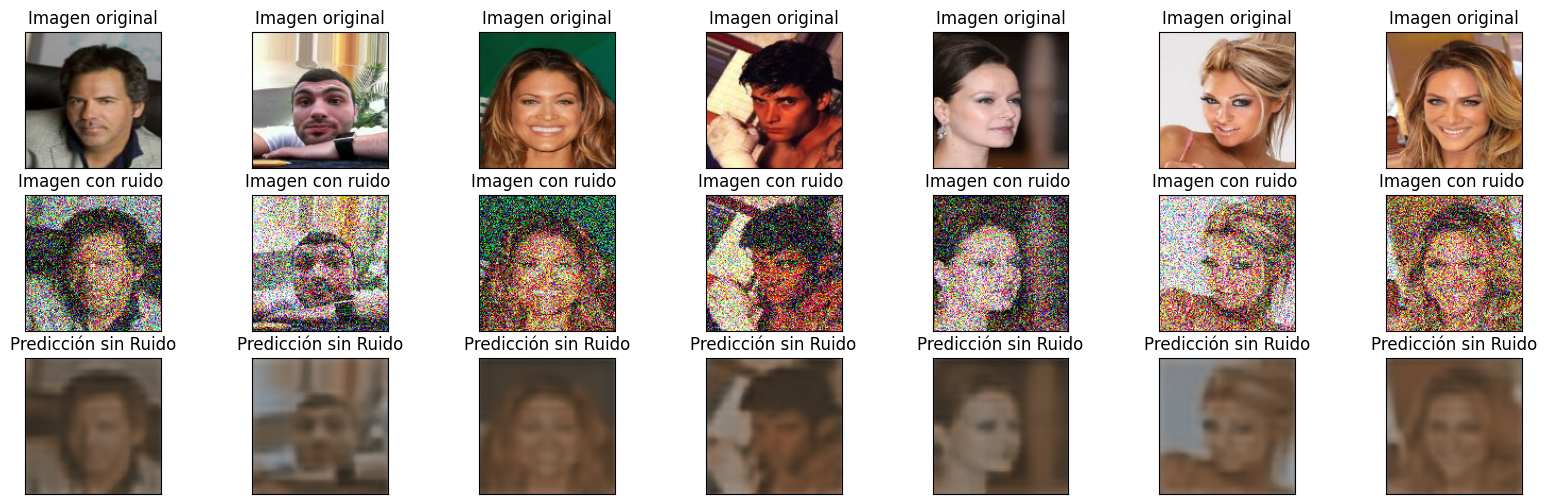

In [ ]:
import matplotlib.pyplot as plt

# Obtener algunas muestras de datos de prueba
sample_originals, sample_noisy = next(iter(test_dataset))

# Obtener las predicciones del modelo para las imágenes con ruido
decoded_images = autoencoder.predict(sample_noisy)

n = 7  # número de muestras para graficar
plt.figure(figsize=(20, 6))
for i in range(n):
     # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_noisy[i])
    plt.title("Imagen original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen con ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(sample_originals[i])
    plt.title("Imagen con ruido ")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Predicción del modelo
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_images[i])
    plt.title("Predicción sin Ruido")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Este segundo modelo demuestra la capacidad de suprimir el ruido presente en las imágenes, sin embargo, las imágenes resultantes muestran un aspecto borroso y falta de nitidez. Aunque el ruido ha sido efectivamente eliminado, las imágenes predichas exhiben una calidad visual mala, caracterizada por una apariencia difusa y tonalidades marrones. Es importante destacar que, a pesar de la reducción del ruido, la pérdida de nitidez puede afectar la utilidad y la interpretación de las imágenes resultantes.

## Modelo 3

Número de Filtros y Tamaño de Filtros Reducidos: En el modelo 3, se han reducido el número de filtros en las capas Conv2D en comparación con los modelos anteriores. Por ejemplo, la primera capa Conv2D del codificador tiene 32 filtros en lugar de 64 en el modelo 2 y 32 en lugar de 64 en el modelo 1. Además, el tamaño del kernel se mantiene en 3x3, similar al modelo 2.

Mayor Tasa de Dropout: Se ha aumentado la tasa de dropout en el modelo 3. Mientras que los modelos anteriores tenían una tasa de dropout de 0.2, el modelo 3 tiene una tasa de dropout de 0.3. Esto implica una mayor probabilidad de ignorar nodos durante el entrenamiento, lo que puede ayudar a prevenir el sobreajuste.

Regularización L2 en una Capa Diferente: A diferencia del modelo 2, donde se aplicaba regularización L2 en algunas capas Conv2D específicas, en el modelo 3, la regularización L2 se aplica en una capa Conv2D diferente (en la tercera capa en lugar de la segunda).

Cambios en el Tamaño del Lote (Batch Size): El tamaño del lote durante el entrenamiento se ha aumentado significativamente en el modelo 3. Mientras que en los modelos anteriores se utilizaban tamaños de lote más pequeños (12 en el modelo 2 y no especificado en el modelo 1), en el modelo 3 se utiliza un tamaño de lote de 128. Esto puede influir en la estabilidad del entrenamiento y en la convergencia del modelo.

Número de Épocas de Entrenamiento Diferentes: El modelo 3 se entrena durante 10 épocas, mientras que el modelo 2 se entrena durante 6 épocas y no se proporciona información sobre el número de épocas en el modelo 1. Un mayor número de épocas de entrenamiento puede permitir una mejor optimización del modelo, aunque puede aumentar el riesgo de sobreajuste si no se controla adecuadamente.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

input_shape = (128, 128, 3)
latent_dim = 256
# Codificador
encoder_inputs = Input(shape=input_shape)
x = Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2, padding='same')(x)
x = Dropout(0.3)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, padding='same')(x)
x = Dropout(0.3)(x)
x = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D(2, padding='same')(x)

# Decodificador
x = Conv2D(128, 3, activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D(2)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D(2)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D(2)(x)
decoded = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(encoder_inputs, decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Definir el callback EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo con el callback EarlyStopping
autoencoder.fit(train_dataset, epochs=10, batch_size=128, validation_data=test_dataset, callbacks=[early_stopping_callback])


Epoch 1/10
1267/1267 [==============================] - 504s 386ms/step - loss: 0.0195 - val_loss: 0.0091
Epoch 2/10
1267/1267 [==============================] - 462s 364ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 3/10
1267/1267 [==============================] - 453s 357ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/10
1267/1267 [==============================] - 464s 366ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 5/10
1267/1267 [==============================] - 448s 353ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 6/10
1267/1267 [==============================] - 459s 362ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 7/10
1267/1267 [==============================] - 471s 372ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 8/10
1267/1267 [==============================] - 467s 368ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 9/10
1267/1267 [==============================] - 465s 367ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 10/10
1267/1267 [=======================

4/4 [==============================] - 0s 21ms/step


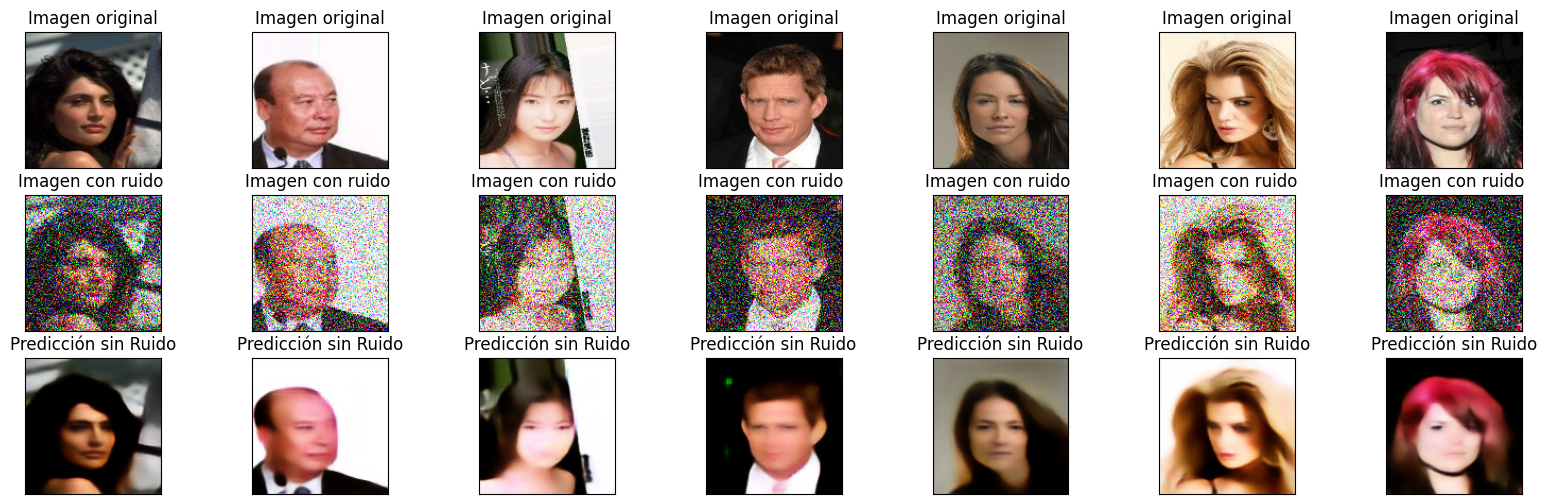

In [ ]:
import matplotlib.pyplot as plt

# Obtener algunas muestras de datos de prueba
sample_originals, sample_noisy = next(iter(test_dataset))

# Obtener las predicciones del modelo para las imágenes con ruido
decoded_images = autoencoder.predict(sample_noisy)

n = 7  # número de muestras para graficar
plt.figure(figsize=(20, 6))
for i in range(n):
     # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_noisy[i])
    plt.title("Imagen original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen con ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(sample_originals[i])
    plt.title("Imagen con ruido ")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Predicción del modelo
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_images[i])
    plt.title("Predicción sin Ruido")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Este tercer modelo también logra efectivamente eliminar el ruido presente en las imágenes, sin embargo, las imágenes resultantes exhiben un nivel considerable de borrosidad, aunque los rostros son distinguibles. Aunque se ha mantenido la fidelidad en cuanto al color y otros aspectos visuales, la pérdida de nitidez en los rostros puede ser notable. A pesar de este efecto indeseado, la capacidad del modelo para preservar otros atributos visuales es un aspecto positivo a tener en cuenta.

## Conclusión

* En conclusión, los denoising autoencoders demostraron ser herramientas sumamente efectivas para la eliminación del ruido en imágenes. Aunque la calidad de las imágenes restauradas puede variar según la naturaleza y la intensidad del ruido inicial, nuestros resultados indican una capacidad constante para reducir el ruido en todas las variantes de los modelos. A pesar de que las imágenes restauradas no alcanzaron una nitidez perfecta en el modelo 2, se observó que el reconocimiento de los elementos principales en los retratos fue generalmente viable, destacando especialmente el modelo 1 por su notable habilidad para restaurar imágenes con mayor claridad visual.


* Estos hallazgos respaldan la viabilidad y el potencial de los denoising autoencoders como herramientas efectivas para el procesamiento de imágenes. Además, estos modelos tienen aplicaciones potenciales en una variedad de campos, incluyendo la medicina para mejorar la calidad de las imágenes de resonancia magnética o tomografías computarizadas, en la seguridad para mejorar la visibilidad en imágenes de vigilancia, en la industria automotriz para la detección de objetos en entornos ruidosos, y en la fotografía digital para la restauración de imágenes dañadas o afectadas por el ruido.

## Desafíos encontrados

Algunos desafíos encontrados incluyen la incompatibilidad del dataset en TensorFlow, lo que me llevó a buscar alternativas para entrenar los modelos sin tener que descargar y cargar el dataset en Colab, ya que esto provocaba un consumo excesivo de memoria RAM. Además, al intentar entrenar los modelos con un mayor número de épocas, la GPU se desconectaba, lo que dificultaba el proceso de entrenamiento y prolongaba los tiempos de desarrollo. Estos obstáculos resaltan la necesidad de encontrar soluciones eficientes para el manejo de grandes volúmenes de datos y la optimización de recursos computacionales al trabajar con denoising autoencoders.
